<a href="https://colab.research.google.com/github/jpmedras/inf450_2023-1/blob/main/Trabalho_inf450_2023_Valgrind_Simulador_de_Cache.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabalho com  Valgrind e  Simulação de Cache: **Cachegrind**

* [Introdução ao Trabalho](https://youtu.be/NMGbFyh2Q78)




Este laboratório apresenta o uso da ferramenta cachegrind do ambiente Valgrind, [para maiores informações consulte aqui](https://valgrind.org/docs/manual/cg-manual.html)

**Importante**:
* A primeira execução do Cachegrind irá fazer a instalação da ferramenta e pode demorar um pouco mais.
* Os laboratorios usam uma multiplicação de matrizes como exemplo. O tamanho da matriz cresce com  $O(N^2)$ e o tempo de execução com $O(N^3)$.
* Os exemplos estão em C. Mas o Cachegrind trabalha sobre o executável e pode ser usado em qualquer binário.
* Fique a vontade para contribuir. Qualquer dúvidas escreva para ricardo@ufv.br


## Inicialização

Primeiro, configurar o laboratório.

In [1]:
!pip install git+https://github.com/lesc-ufv/cad4u >& /dev/null
!git clone https://github.com/lesc-ufv/cad4u >& /dev/null
%load_ext plugin

# Cache de Dados

Criamos a extensão **\%\%datacache**, onde um código em C pode ser adicionado e compilado, para depois ser executado com  **cachegrind**. A cache de instrução tem o default: 32K, linhas de 64 Bytes, 8-way. A cache LL (Last level Cache) tem tamanho default de
58.720.256 Bytes, linhas de 64 Bytes, 28-way.

Criamos uma interface amigável onde o usuário especifica os parametros da cache de dados. Depois basta clicar no  **Start Execution** para ter os resultados de falhas (miss) e da taxa de falhas (miss rate).

Caso, voce execute mais de uma vez, os resultados ficam temporariamente na sessão para efeitos de comparação.


In [8]:
%%datacache
#include <stdio.h>
#include <stdlib.h>

int main(int argc, char const *argv[]) {

  int n = 90;
  char a[n][n], b[n][n], c[n][n];

  int s = 0;
  for (int i = 0; i < n; ++i) {
      for (int j = 0; j < n; ++j) {
        a[i][j] = i + j;
        b[i][j] = i*2 + j;
      }
  }

  int temp;
  for (int i = 0; i < n; ++i) {
      for (int j = 0; j < n; ++j) {
          temp = 0;
          for (int k = 0; k < n; ++k) {
              temp += a[i][k] * b[k][j];
          }
          c[i][j] = temp;
      }
  }

  return 0;
}

GridspecLayout(children=(Button(button_style='warning', description='Data Cache', layout=Layout(grid_area='wid…

------------------------------------------------------------
Parameters: 4096, 1, 32

D   refs:       9,014,836  (8,962,454 rd   + 52,382 wr)
D1  misses:       163,563  (  155,338 rd   +  8,225 wr)
LLd misses:         2,011  (    1,180 rd   +    831 wr)
D1  miss rate:        1.8% (      1.7%     +   15.7%  )
LLd miss rate:        0.0% (      0.0%     +    1.6%  )

LL refs:          164,485  (  156,260 rd   +  8,225 wr)
LL misses:          2,923  (    2,092 rd   +    831 wr)
LL miss rate:         0.0% (      0.0%     +    1.6%  )
------------------------------------------------------------


## Outros Resultados

Cada simulação irá criar um arquivo temporário com o número do processo **cachegrind.out.**\<NumeroProcesso\>.

O comando abaixo lista as execuções que já foram realizadas.

In [ ]:
!ls -la cachegrind*

-rw------- 1 root root 79151 May  8 21:26 cachegrind.out.1901


In [ ]:
# Podemos listar o arquivo, mas o arquivo é grande 120K, tem muitas informações
# Abaixo um exemplo (adaptar para o seu numero de processo) para ver apenas os tamanhos das caches.
!grep desc cachegrind.out.1063

grep: cachegrind.out.1063: No such file or directory


# Parte I

In [3]:
# Digitar a lista das matriculas

Mat = [105460, 105463, 105466, 105468, 105475]

In [4]:
#@title Gerando a parte I - Tem que **EXECUTAR ESTA CÉLULA !!!**
L = [ ["Cache 2k, Matrix 20x20, 60x60, 90x90 "],["Cache 4k, Matrix 40x40, 60x60, 120x120"],["Cache 2k, Matrix 15x15, 50x50, 100x100. "],
 ["Cache 4k, Matrix 30x30, 60x60, 110x110"],["Cache 8k, Matrix 50x50, 100x100, 150x150."],["Cache 16k, Matrix 80x80, 160x160, 320x320"]]

D = {}
print("Faça os testes usando estes tamanhos: ",L[(sum(Mat)//197)%len(L)])

Faça os testes usando estes tamanhos:  ['Cache 2k, Matrix 20x20, 60x60, 90x90 ']




Fazer três versões da multiplicação de Matrizes

###**a.** Exemplo Anterior

###**b.** Armazenar B na forma transposta para reduzir as falhas no acesso por coluna

###**c.** Fazer a versão com Tile que seja o maior possivel que possa estar armazenado na Cache.

Não considerar as falhas de inicialização.

1. Mantendo o tamanho da cache. A associatividade faz diferença para alguma das três versões em relação a taxa de falhas? Execute para três tamanhos diferentes de matrizes (menor ou igual, maior que a cache) para as três versões e mostre na forma gráfica. Explique os resultados.

2. Mantendo o tamanho da cache. O tamanho do bloco faz diferença para alguma das três versões em relação a taxa de falhas? Explique os resultados e mostre na forma gráfica.

## Parte A

In [25]:
%%datacache
#include <stdio.h>
#include <stdlib.h>

int main(int argc, char const *argv[]) {

  int n = 90;
  char a[n][n], b[n][n], c[n][n];

  int s = 0;
  for (int i = 0; i < n; ++i) {
      for (int j = 0; j < n; ++j) {
        a[i][j] = i + j;
        b[i][j] = i*2 + j;
        c[i][j] = 0;
      }
  }

  for (int i = 0; i < n; ++i) {
      for (int j = 0; j < n; ++j) {
          for (int k = 0; k < n; ++k) {
              c[i][j] += a[i][k] * b[k][j];
          }
      }
  }

  return 0;
}

GridspecLayout(children=(Button(button_style='warning', description='Data Cache', layout=Layout(grid_area='wid…

------------------------------------------------------------
Parameters: 4096, 1, 32

D   refs:      14,101,636  (13,328,354 rd   + 773,282 wr)
D1  misses:       233,398  (   207,556 rd   +  25,842 wr)
LLd misses:         2,011  (     1,180 rd   +     831 wr)
D1  miss rate:        1.7% (       1.6%     +     3.3%  )
LLd miss rate:        0.0% (       0.0%     +     0.1%  )

LL refs:          234,321  (   208,479 rd   +  25,842 wr)
LL misses:          2,924  (     2,093 rd   +     831 wr)
LL miss rate:         0.0% (       0.0%     +     0.1%  )
------------------------------------------------------------
------------------------------------------------------------
Parameters: 4096, 4, 32

D   refs:      14,101,636  (13,328,354 rd   + 773,282 wr)
D1  misses:        42,604  (    40,704 rd   +   1,900 wr)
LLd misses:         2,011  (     1,180 rd   +     831 wr)
D1  miss rate:        0.3% (       0.3%     +     0.2%  )
LLd miss rate:        0.0% (       0.0%     +     0.1%  )

LL refs:   

## 20
associative = [1, 4, 16]
misses = [7611, 4232, 4124]

## 60
associative = [1, 4, 16]
misses = [63177, 32842, 5687]

## 90
associative = [1, 4, 16]
misses = [233398, 42604, 28325]

## Parte B

In [17]:
%%datacache
#include <stdio.h>
#include <stdlib.h>

int main(int argc, char const *argv[]) {

  int n = 20;
  char a[n][n], b[n][n], c[n][n];

  int s = 0;
  for (int i = 0; i < n; ++i) {
      for (int j = 0; j < n; ++j) {
        a[i][j] = i + j;
        b[j][i] = i*2 + j;
        c[i][j] = 0;
      }
  }

  for (int i = 0; i < n; ++i) {
      for (int j = 0; j < n; ++j) {
          for (int k = 0; k < n; ++k) {
              c[i][j] += a[i][k] * b[j][k];
          }
      }
  }

  return 0;
}

GridspecLayout(children=(Button(button_style='warning', description='Data Cache', layout=Layout(grid_area='wid…

------------------------------------------------------------
Parameters: 2048, 1, 32

D   refs:      14,101,636  (13,328,354 rd   + 773,282 wr)
D1  misses:       403,906  (   342,986 rd   +  60,920 wr)
LLd misses:         2,011  (     1,180 rd   +     831 wr)
D1  miss rate:        2.9% (       2.6%     +     7.9%  )
LLd miss rate:        0.0% (       0.0%     +     0.1%  )

LL refs:          404,829  (   343,909 rd   +  60,920 wr)
LL misses:          2,924  (     2,093 rd   +     831 wr)
LL miss rate:         0.0% (       0.0%     +     0.1%  )
------------------------------------------------------------


## Parte C

In [20]:
%%datacache
#include <stdio.h>
#include <stdlib.h>

int main(int argc, char const *argv[]) {

  int n = 90;
  char a[n][n], b[n][n], c[n][n];
  int tilesize=8;

  int s = 0;
  for (int i = 0; i < n; ++i) {
      for (int j = 0; j < n; ++j) {
        a[i][j] = i + j;
        b[i][j] = i*2 + j;
        c[i][j] = 0;
      }
  }

  for (int ih = 0; ih < n; ih += tilesize) {                         ///\lilabel{block_loop_i}
    for (int jh = 0; jh < n; jh += tilesize) {                       ///\lilabel{block_loop_k}
      for (int kh = 0; kh < n; kh += tilesize) {                     ///\lilabel{block_loop_j}
        for (int il = 0; il < tilesize; ++il) {                      ///\lilabel{base_loop_i}
          for (int kl = 0; kl < tilesize; ++kl) {                    ///\lilabel{base_loop_k}
            for (int jl = 0; jl < tilesize; ++jl) {                  ///\lilabel{base_loop_j}
              c[ih+il][jh+jl] += a[ih+il][kh+kl] * b[kh+kl][jh+jl];  ///\lilabel{base_multiply}
        } } }
      }
    }
  }

  return 0;
}

GridspecLayout(children=(Button(button_style='warning', description='Data Cache', layout=Layout(grid_area='wid…

------------------------------------------------------------
Parameters: 2048, 1, 32

D   refs:      24,443,688  (23,463,849 rd   + 979,839 wr)
D1  misses:       494,280  (   432,227 rd   +  62,053 wr)
LLd misses:         2,011  (     1,180 rd   +     831 wr)
D1  miss rate:        2.0% (       1.8%     +     6.3%  )
LLd miss rate:        0.0% (       0.0%     +     0.1%  )

LL refs:          495,206  (   433,153 rd   +  62,053 wr)
LL misses:          2,927  (     2,096 rd   +     831 wr)
LL miss rate:         0.0% (       0.0%     +     0.1%  )
------------------------------------------------------------


# Variando o tamanho da Cache e visualizando falhas e taxa de falhas

A extensão **\%\%rangecachegrind** executa várias vezes com tamanhos de cache especificados pela lista **datacache=(4,8,16,32)**, em Kbytes. O usuário especifica a associatividade (**ways**) e o tamanho do linha  (**line**), os gráficos são gerados de forma automática.

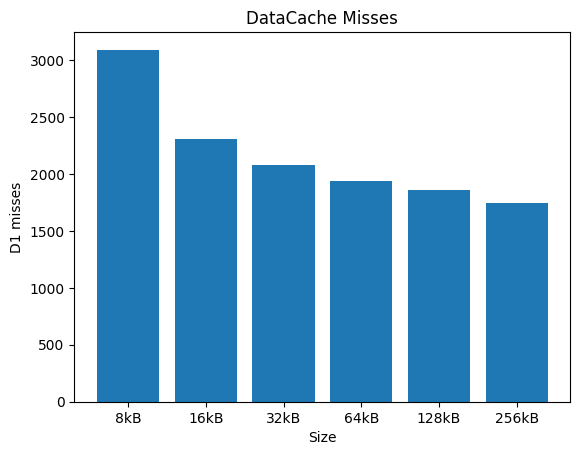

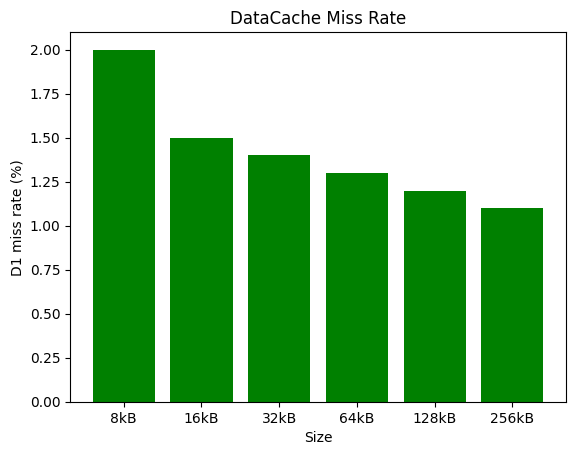

In [ ]:
%%rangecachegrind datacache=(8,16,32,64,128,256); ways=2; line=64; bargraph=(misses, miss_rate)

#include <stdio.h>
#include <stdlib.h>

int main(int argc, char const *argv[]) {

  int n = 2048;
  int a[n][n], b[n][n], c[n][n];

  for (int i = 0; i < n; ++i) {
      for (int j = 0; j < n; ++j) {
        a[i][j] = i + j;
        b[i][j] = i*2 + j;
      }
  }

  int temp;
  for (int i = 0; i < n; ++i) {
      for (int j = 0; j < n; ++j) {
          temp = 0;
          for (int k = 0; k < n; ++k) {
              temp += a[i][k] * b[k][j];
          }
          c[i][j] = temp;
      }
  }
  return 0;
}

# Parte II

Executar os três códigos com rangegridcache e plotar os grafos.

# Parte III

[escolher 4 versões de código neste repositório](https://github.com/neboat/Moore) para compilar e executar diretamente no colab, sem usar o Valgrind. Medir o tempo com **time** do SO ou alterar o código para usar **chromos**. Fazer uma tabela das 4 implementações com matrizes de três tamanhos: N=1024, N=2048 e N=4096. A Cache L3 do processador do Colab tem 56 MB. Além da tabela fazer um gráfico dos resultados (tempo de execução para cada versão em função do tamanho).


In [ ]:
!lscpu

Architecture:                    x86_64
CPU op-mode(s):                  32-bit, 64-bit
Byte Order:                      Little Endian
Address sizes:                   46 bits physical, 48 bits virtual
CPU(s):                          2
On-line CPU(s) list:             0,1
Thread(s) per core:              2
Core(s) per socket:              1
Socket(s):                       1
NUMA node(s):                    1
Vendor ID:                       GenuineIntel
CPU family:                      6
Model:                           79
Model name:                      Intel(R) Xeon(R) CPU @ 2.20GHz
Stepping:                        0
CPU MHz:                         2199.998
BogoMIPS:                        4399.99
Hypervisor vendor:               KVM
Virtualization type:             full
L1d cache:                       32 KiB
L1i cache:                       32 KiB
L2 cache:                        256 KiB
L3 cache:                        55 MiB
NUMA node0 CPU(s):               0,1
Vulnerability 

# Questão 1 da Prova 3

Abaixo sugestões de exercicios para a questão 1 da prova 3

## Suponha uma cache com bloco de 4 bytes e 16 posições mapeamento direto.

Para o código abaixo, após 20 acessos a memória (pode ser de A, B ou C...) Qual será o conteúdo da cache. Suponha que **temp, i, j, k** sejam registradores ? Quantas falhas terão ? Suponha que a cache esteja vazia na execução do trecho.

```
  byte a[4][4], b[4][4], c[4][4];

  int temp;
  for (int i = 0; i < 4; ++i) {
      for (int j = 0; j < 4; ++j) {
          temp = 0;
          for (int k = 0; k < 4; ++k) {
              temp += a[i][k] * b[k][j];
          }
          c[i][j] = temp;
      }
  }
```

## Outras  opções para questão anterior:

* Cache de 32 ou 64, o que modifica ?
* Bloco de 8 ?
* 2-way ?
* suponha que o acesso para matriz B seja por linha (a matriz foi transposta na memória antes de executar o código).



# Pontos Extras

* Fazer a analise para cache com 16 e 32 para a versão com Tile, considerando 2x2 para a execução dos 30 primeiros acessos. (2 pontos)
* Fazer um simulador que gere os a contagem do acesso para uma cache de mapeamento direto onde o tamanho da cache, do bloco, da matriz e do tile são parametros (5 pontos).